In [1]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt

### Read trial data and timeseries into pandas:

In [2]:
data=pd.read_csv('data.csv', sep=',')

rows = []
csv_header = ["Block_Name","Block_Nr","exp_subject_id","rec_session_id","session_nr","Task_Name",
                                                           "Task_Nr","times","Trial_Id","Trial_Nr",
                                                           "variable_name","values"]
with open('timeseries.csv', 'r') as f_input:
    reader = csv.DictReader(f_input, delimiter=',', fieldnames=csv_header[:-1], restkey=csv_header[-1], skipinitialspace=True)
    next(reader)
    for row in reader:
        row_part1 = [row[fname] for fname in csv_header[:-1]]
        if len(row['values']) < 2:
            row['values'].append('')
        new_row = row_part1 + row['values']
        rows.append(new_row)

frame_header = csv_header[:-1] + ["x", "y"]
timeseries = pd.DataFrame(rows, columns=frame_header)


numeric_columns = ["Block_Nr","exp_subject_id","rec_session_id","session_nr",
                                                           "Task_Nr","times","Trial_Id","Trial_Nr",
                                                           "x", "y"]

for col in numeric_columns:
    timeseries[col] = pd.to_numeric(timeseries[col])
    
timeseries = timeseries[timeseries.variable_name.eq('XYGaze')]

### Evaluate accuracy of every trial and every subject:

In [3]:
results = []
frame_width = 800
frame_height = 450
t_min = 1000
t_max = 6000
visual_degree_scaling = 25

for rec_session_id in data.rec_session_id.unique():
    subj_data = data[data.Task_Name.eq('testing') & data.rec_session_id.eq(rec_session_id)]
    for fixation_idx, row in subj_data.iterrows():
        time_pts = timeseries[timeseries.Task_Nr.eq(row.Task_Nr) & timeseries.rec_session_id.eq(rec_session_id) & timeseries.Trial_Id.eq(row.Trial_Id)]

        # remove initial NaN values at start of trials:
        time_pts = time_pts[time_pts['x'].notnull()]
        time_pts = time_pts[time_pts['y'].notnull()]
        
        # change timestamps to start at 0 for each trial:
        time_pts['times'] = time_pts['times'] - time_pts['times'].iloc[0]

        # filter samples that are between t_min and t_max within the trial:
        time_pts = time_pts[time_pts['times'] > t_min]
        time_pts = time_pts[time_pts['times'] < t_max]

        # remove samples where gaze prediction is outside screen:
        time_pts = time_pts[time_pts['x'] > 0]
        time_pts = time_pts[time_pts['y'] > 0]
        time_pts = time_pts[time_pts['x'] < frame_width]
        time_pts = time_pts[time_pts['y'] < frame_height]
        
        if time_pts.shape[0] < 5:
            continue
        
        XCorr = row.XCorr
        YCorr = row.YCorr
        
        xDiff = np.abs(time_pts.x - XCorr) / visual_degree_scaling
        yDiff = np.abs(time_pts.y - YCorr) / visual_degree_scaling
    
        spatialPrecisionX = np.sqrt(np.mean(xDiff**2))
        spatialPrecisionY = np.sqrt(np.mean(yDiff**2))
        spatialAccuracyX = np.mean(xDiff)
        spatialAccuracyY = np.mean(yDiff)
        
        results.append({
            'rec_session_id': rec_session_id,  
            'spatialAccuracyX': spatialAccuracyX,  
            'spatialAccuracyY': spatialAccuracyY,
            'spatialPrecisionX': spatialPrecisionX,  
            'spatialPrecisionY': spatialPrecisionY
        })

results = pd.DataFrame(results)

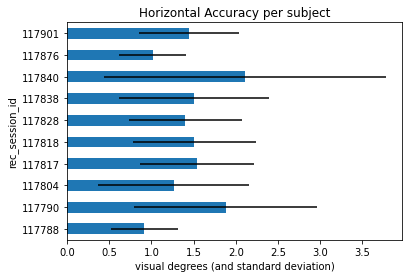

In [4]:
results_agg = results.groupby("rec_session_id").agg([np.mean, np.std])
results_agg['spatialAccuracyX'].plot(kind = "barh", y = "mean", legend = False, title = "Horizontal Accuracy per subject", xerr = "std")
plt.xlabel('visual degrees (and standard deviation)')
plt.show()

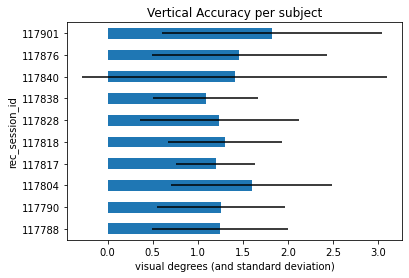

In [5]:
results_agg = results.groupby("rec_session_id").agg([np.mean, np.std])
results_agg['spatialAccuracyY'].plot(kind = "barh", y = "mean", legend = False, title = "Vertical Accuracy per subject", xerr = "std")
plt.xlabel('visual degrees (and standard deviation)')
plt.show()

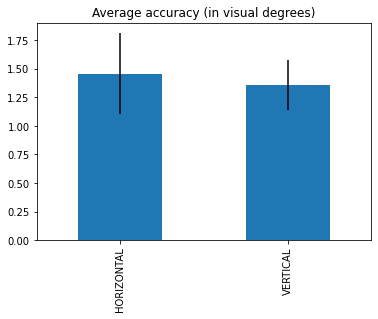

Average horizontal accuracy:1.4574847113258846°
Average vertical accuracy:1.3608288841811755°


In [6]:
results_agg = results.groupby("rec_session_id").agg(np.mean)
results_grand_mean = results_agg.agg([np.mean,np.std])
values = [[results_grand_mean["spatialAccuracyX"]["mean"],results_grand_mean["spatialAccuracyX"]["std"]], [results_grand_mean["spatialAccuracyY"]["mean"],results_grand_mean["spatialAccuracyY"]["std"]]]
toplot = pd.DataFrame(values,columns=['mean','std'], index=['HORIZONTAL','VERTICAL'])
toplot.plot(kind = "bar", y = "mean", legend = False, title = "Average accuracy (in visual degrees)", yerr = "std")
plt.show()
print("Average horizontal accuracy:" + str(results_grand_mean["spatialAccuracyX"]["mean"])+"°")
print("Average vertical accuracy:" + str(results_grand_mean["spatialAccuracyY"]["mean"])+"°")